In [4]:
from os.path import join
import pandas as pd
import numpy as np
df=pd.read_csv(r'C:\Users\quilo\Desktop\Classification\labels.csv')
df['files']=df['id']+'.jpg'
rows = np.random.randint(2, size=len(df)).astype('bool')
df_cal=df[rows]
df_test=df[~rows]
y_cal=df_cal['breed'].values
y_test=df_test['breed'].values


#df=df[df['breed']=='english_springer']

image_dir = r'C:\Users\quilo\Desktop\Classification'
img_paths_cal = [join(image_dir, filename) for filename in df_cal['files'].values]
img_paths_test = [join(image_dir, filename) for filename in df_test['files'].values]

In [6]:
import numpy as np
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array

image_size = 224

def read_and_prep_images(img_paths, img_height=image_size, img_width=image_size):
    imgs = [load_img(img_path, target_size=(img_height, img_width)) for img_path in img_paths]
    img_array = np.array([img_to_array(img) for img in imgs])
    output = preprocess_input(img_array)
    return(output)

In [7]:
from tensorflow.keras.applications import ResNet50

my_model = ResNet50(weights='imagenet')
cal_data=read_and_prep_images(img_paths_cal)
test_data=read_and_prep_images(img_paths_test)
y_cal_preds = my_model.predict(cal_data)

In [9]:
# importing the module
import json
 
# Opening JSON file
with open(r'C:\Users\quilo\Desktop\Classification\imagenet_class_index.json') as json_file:
    decoder = json.load(json_file)
d={}

for k,v in decoder.items():
    d[v[1]]=int(k)
    decoder[k]=v[1]

In [10]:
alpha=0.1
n=len(y_cal)
scores=[]

for i in range(y_cal_preds.shape[0]):
    try:
        scores.append(1-y_cal_preds[i][d[y_cal[i]]])
    except Exception:
        pass
    
scores=np.array(scores)
q_yhat=np.quantile(scores,np.ceil((n+1)*(1-alpha))/n)


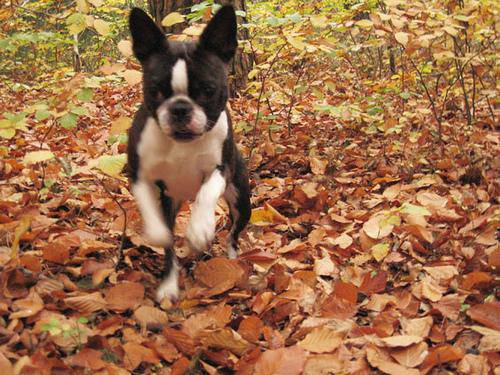

[['Boston_bull', 0.9917393]]  Ground truth:boston_bull


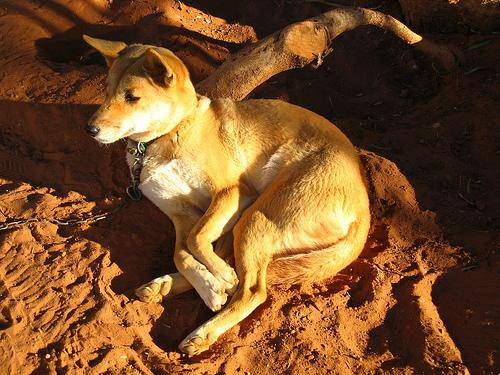

[['dingo', 0.9726337]]  Ground truth:dingo


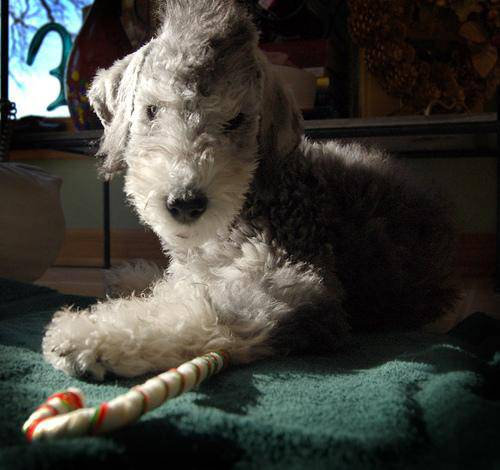

[['Bedlington_terrier', 0.81038165], ['wire-haired_fox_terrier', 0.06961714], ['Lakeland_terrier', 0.11921686]]  Ground truth:bedlington_terrier


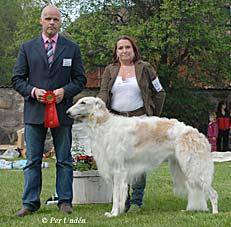

[['borzoi', 0.9979881]]  Ground truth:borzoi


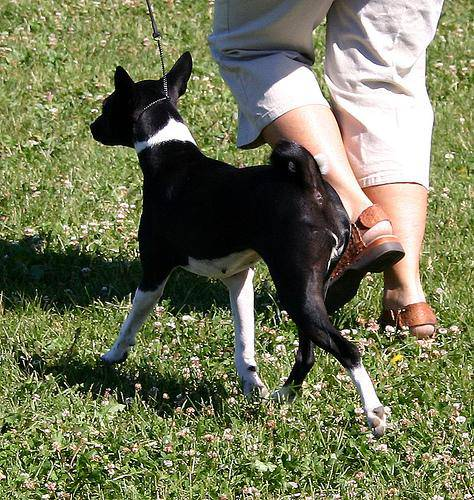

[['Boston_bull', 0.4607816], ['basenji', 0.509923]]  Ground truth:basenji


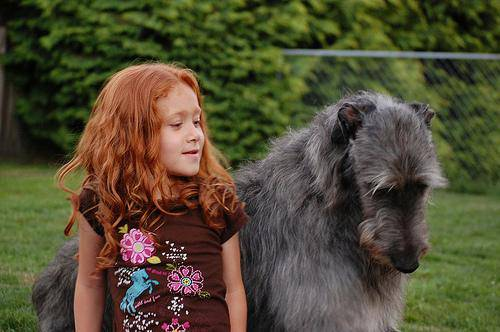

[['Irish_wolfhound', 0.08127375], ['Scottish_deerhound', 0.9184494]]  Ground truth:scottish_deerhound


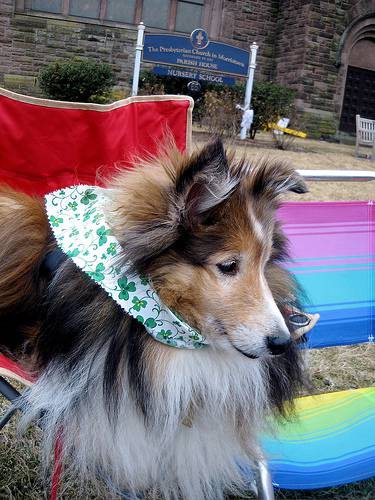

[['Shetland_sheepdog', 0.9765622]]  Ground truth:shetland_sheepdog


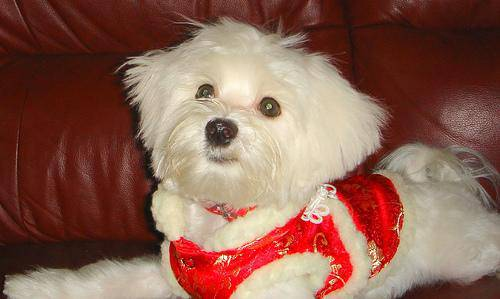

[['Maltese_dog', 0.6501385], ['Lhasa', 0.3150221]]  Ground truth:maltese_dog


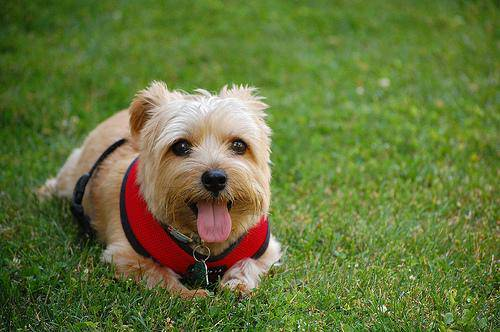

[['Norfolk_terrier', 0.28591424], ['Norwich_terrier', 0.10372889], ['cairn', 0.068172224], ['Dandie_Dinmont', 0.3683918], ['West_Highland_white_terrier', 0.12020066]]  Ground truth:norfolk_terrier


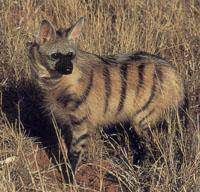

[['African_hunting_dog', 0.14886713], ['hyena', 0.8368064]]  Ground truth:african_hunting_dog


In [18]:
from IPython.display import Image, display

def build_conf_sets(y_pred,q_yhat):
    conf_set=[]
    
    for i in range(y_pred.shape[0]):
        aux=[]
        for j in range(y_pred.shape[1]):
            if y_pred[i][j]>=1-q_yhat:
                aux.append([j,y_pred[i][j]])
        conf_set.append(aux)
    
    return conf_set
    

y_test_preds = my_model.predict(test_data)
conf_sets=build_conf_sets(y_test_preds,q_yhat)
k=10

for i, img_path in enumerate(img_paths_test):
    breeds=[]
    for item in conf_sets[i]:
        breeds.append([decoder[str(item[0])],item[1]])
    if i<k:
        display(Image(img_path))
        print(breeds,' Ground truth:'+str(y_test[i]))
    
   # print(most_likely_labels[i])

In [15]:
df_test

,id,breed,files
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull,000bec180eb18c7604dcecc8fe0dba07.jpg
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo,001513dfcb2ffafc82cccf4d8bbaba97.jpg
6,00290d3e1fdd27226ba27a8ce248ce85,bedlington_terrier,00290d3e1fdd27226ba27a8ce248ce85.jpg
7,002a283a315af96eaea0e28e7163b21b,borzoi,002a283a315af96eaea0e28e7163b21b.jpg
8,003df8b8a8b05244b1d920bb6cf451f9,basenji,003df8b8a8b05244b1d920bb6cf451f9.jpg
...,...,...,...
10198,ff6f47aa8e181b6efa4d0be7b09b5628,golden_retriever,ff6f47aa8e181b6efa4d0be7b09b5628.jpg
10203,ff91c3c095a50d3d7f1ab52b60e93638,affenpinscher,ff91c3c095a50d3d7f1ab52b60e93638.jpg
10206,ffa16727a9ee462ee3f386be865b199e,irish_wolfhound,ffa16727a9ee462ee3f386be865b199e.jpg
10215,ffcde16e7da0872c357fbc7e2168c05f,airedale,ffcde16e7da0872c357fbc7e2168c05f.jpg
